In [36]:
import os, glob, sqlite3
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

In [37]:
os.makedirs("AI Research Dataset", exist_ok=True)
Dataset_Path = os.path.join("AI Research Dataset","AI Research Paper Dataset.csv")

In [38]:
Dataset = pd.read_csv(Dataset_Path)

In [39]:
class SQLite3:
    def __init__(self, Dataset , Name):
        self.Dataset = Dataset
        self.Name = Name
        
    def SQLite3_Connection(self):
        if self.Name + ".db" not in glob.glob("*db"):
            Connection = sqlite3.connect(self.Name + ".db")
            self.Dataset.to_sql(self.Name, Connection, if_exists='replace', index=False)
            print("Database already created!")
            return Connection
        else: return sqlite3.connect(self.Name + ".db")

    def Exc(self, Query):
        Connection = self.SQLite3_Connection()
        return pd.read_sql_query(Query, Connection)

In [40]:
class Dataset_Cleanning:
    def __init__(self, Dataset):
        self.Dataset = Dataset.copy().drop(columns=['Categories', 'Comment', 'Entry ID', 'PDF URL', 'Journal Ref', 'DOI'])
        self.Cleaned_Dataset = self.Data_cleaning()

    def Authors_Name_Processing(self, Text):
        Name_Text = Text
        Name = []
        for i in range(len(Name_Text.split("'"))):
            if '.Author(' in Name_Text.split("'")[i]:
                Name.append(Name_Text.split("'")[i+1])
        return ", ".join(Name)

    def Categories_Processing(self, Text):
        Categories_Text = Text
        Categories = []
        for i in Categories_Text.split("'"):
            if 'cs.' in i:
                Categories.append(i.strip('cs.'))
        return ", ".join(Categories)

    def Primary_Category_Processing(self, Text):
        parts = Text.split(".")
        return parts[1] if len(parts) > 1 else None

    def Datetime_Processing(self, Text):
        date_obj = datetime.strptime(Text, "%Y-%m-%d %H:%M:%S%z")
        return date_obj.strftime("%H:%M:%S %d-%m-%Y ")
    
    def Data_cleaning(self):
        self.Dataset['Authors'] = self.Dataset['Authors'].apply(lambda x: self.Authors_Name_Processing(x))
        self.Dataset['Primary Category'] = self.Dataset['Primary Category'].apply(lambda x: self.Primary_Category_Processing(x))

        for col in ['Published', 'Updated']:
            self.Dataset[col] = Dataset[col].apply(lambda x: self.Datetime_Processing(x))
        
        return self.Dataset

In [41]:
def Filtered_keywords(Data, Keywords):
    Filtered_Papers = Data[
        Data['Title'].str.contains('|'.join(Keywords), case=False, na=False) |
        Data['Summary'].str.contains('|'.join(Keywords), case=False, na=False)
    ].copy() 
    return Filtered_Papers

def Year_Format(Data):
    return Data.dt.year

def Result(Data, Keywords):
    Result = Filtered_keywords(Data, Keywords)
    for Column in ['Published', 'Updated']:
        Result[Column] = pd.to_datetime(Result[Column], format="%H:%M:%S %d-%m-%Y ", errors='coerce')
        Result[Column] = Year_Format(Result[Column])
    return Result

In [42]:
Keywords = ['wearable', 'sensor', 'monitoring', 'health']

Table_Name = 'AI Research Paper'
Conn = SQLite3(Result(Dataset_Cleanning(Dataset).Cleaned_Dataset, Keywords), Table_Name)
Query = f"""
    SELECT Published, COUNT(*) AS 'Number of papers'
    FROM '{Table_Name}'
    GROUP BY Published
"""        
Conn.Exc(Query)

,Published,Number of papers
0,1997,1
1,1998,1
2,1999,1
3,2001,1
4,2002,2
5,2003,1
6,2004,6
7,2005,3
8,2007,10
9,2008,5


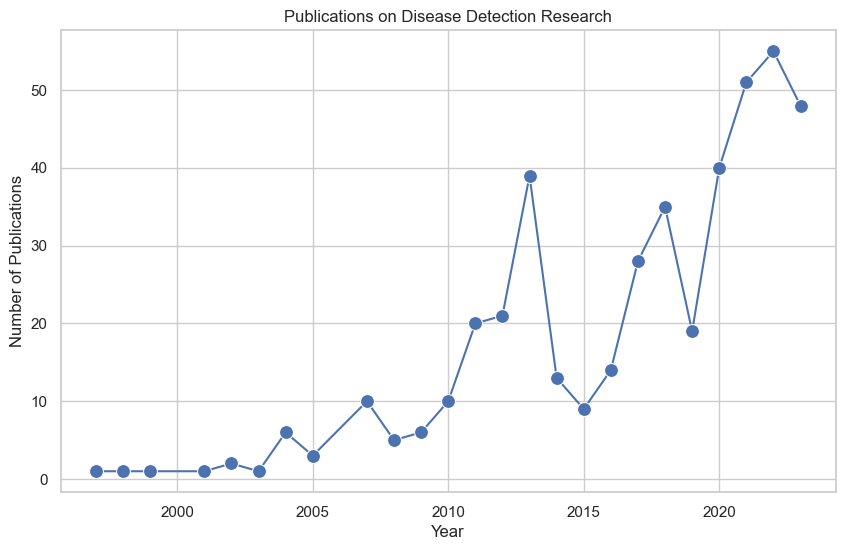

In [52]:
Result(Dataset_Cleanning(Dataset).Cleaned_Dataset, Keywords).to_csv('AI Research Dataset//AI Research Paper Dataset - Cleanned.csv', index=False)
Project_Dataset = Result(Dataset_Cleanning(Dataset).Cleaned_Dataset, Keywords)
Publication_Analysis = Project_Dataset.groupby(Project_Dataset['Published']).size().reset_index(name='Count')

plt.figure(figsize=(10, 6))
sns.set_theme(style="whitegrid")
sns.lineplot(data=Publication_Analysis, x='Published', y='Count', marker='o', markersize=10)
plt.title('Publications on Disease Detection Research')
plt.xlabel('Year')
plt.ylabel('Number of Publications')
plt.show()

In [44]:
# Chuẩn bị văn bản từ cột 'Title' để phân tích chủ đề
vectorizer = CountVectorizer(stop_words='english') # Biến đổi văn bản thành ma trận đếm từ.
X = vectorizer.fit_transform(Project_Dataset['Title']) 
keyword = vectorizer.get_feature_names_out()
print(Keywords[:10])

['wearable', 'sensor', 'monitoring', 'health']


In [45]:
# Chuẩn bị văn bản từ cột 'Summary' để phân tích chủ đề
vectorizer = CountVectorizer(stop_words='english')
X = vectorizer.fit_transform(Project_Dataset['Summary'])

# Phân tích chủ đề bằng Latent Dirichlet Allocation để tìm 5 chủ đề ẩn trong dữ liệu văn bản.
lda = LatentDirichletAllocation(n_components=5, random_state=42) 
lda.fit(X)

LatentDirichletAllocation(n_components=5, random_state=42)

In [53]:
feature_names = vectorizer.get_feature_names_out()

for idx, topic in enumerate(lda.components_):
    print(f"Topic {idx}:")
    print([feature_names[i] for i in topic.argsort()[:-10 - 1:-1]]) # Lấy 10 từ có trọng số cao nhất cho mỗi chủ đề

Topic 0:
['ai', 'data', 'decision', 'paper', 'based', 'systems', 'monitoring', 'healthcare', 'used', 'using']
Topic 1:
['data', 'based', 'model', 'systems', 'learning', 'sensor', 'paper', 'ai', 'knowledge', 'approach']
Topic 2:
['data', 'process', 'based', 'learning', 'medical', 'monitoring', 'model', 'event', 'business', 'real']
Topic 3:
['model', 'monitoring', 'learning', 'uncertainty', 'data', 'sensors', 'human', 'approach', 'using', 'information']
Topic 4:
['learning', 'data', 'using', 'model', 'paper', 'used', 'sensor', 'models', 'agent', 'approach']


In [47]:
Publication_Year_Analysis = Project_Dataset.groupby(Project_Dataset['Published']).size()

X = np.array(Publication_Year_Analysis.index).reshape(-1, 1)
y = Publication_Year_Analysis.values

model = LinearRegression()
model.fit(X, y)

predictions = model.predict(X)
rmse = np.sqrt(np.mean((predictions - y) ** 2))
r_squared = model.score(X, y)

print(f"RMSE: {rmse}, R²: {r_squared}")

RMSE: 8.906235590169048, R²: 0.728878530181204


In [48]:
tree_model = DecisionTreeRegressor()
tree_model.fit(X, y)

tree_predictions = tree_model.predict(X)
tree_rmse = np.sqrt(np.mean((tree_predictions - y) ** 2))
tree_r_squared = tree_model.score(X, y)

print(f"Decision Tree - RMSE: {tree_rmse}, R²: {tree_r_squared}")

Decision Tree - RMSE: 0.0, R²: 1.0


In [49]:
# Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X, y)

# Predict and evaluate
rf_predictions = rf_model.predict(X)
rf_rmse = np.sqrt(np.mean((rf_predictions - y) ** 2))
rf_r_squared = rf_model.score(X, y)

print(f"Random Forest - RMSE: {rf_rmse}, R²: {rf_r_squared}")

Random Forest - RMSE: 2.969158129840847, R²: 0.9698670113861332


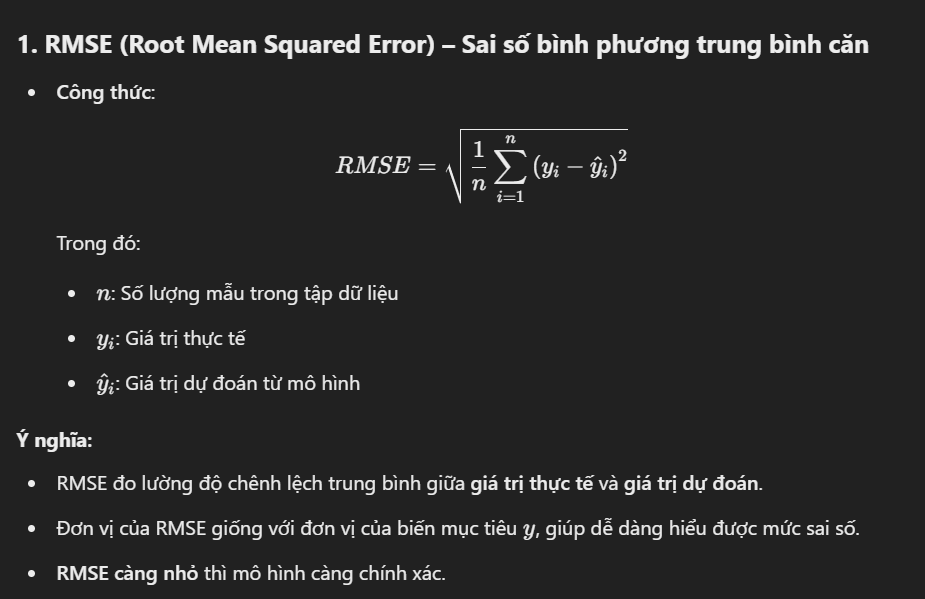

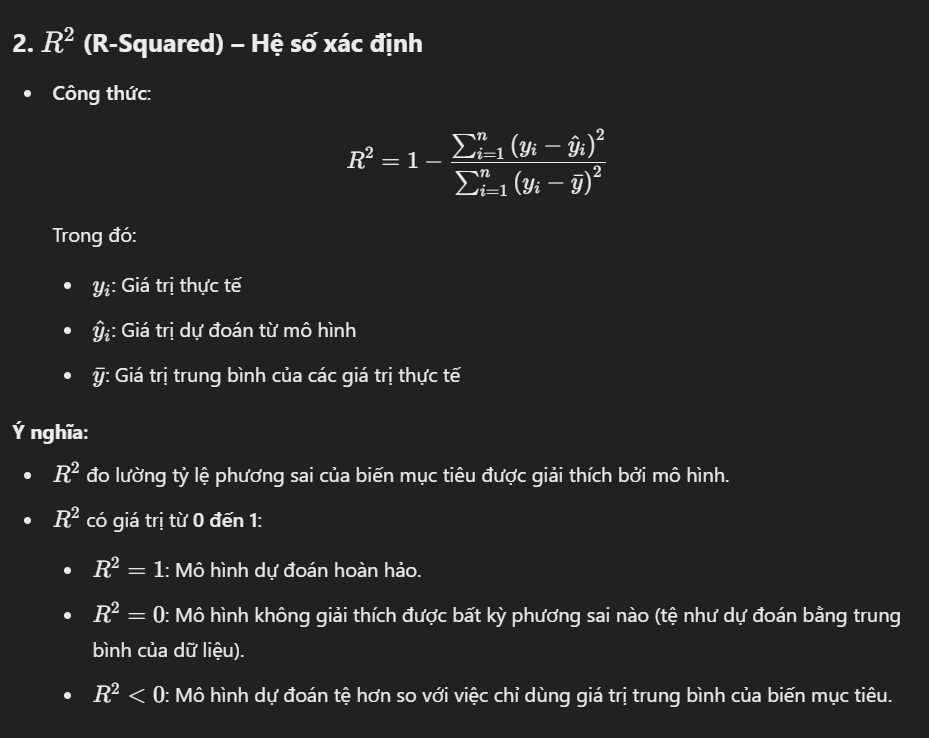

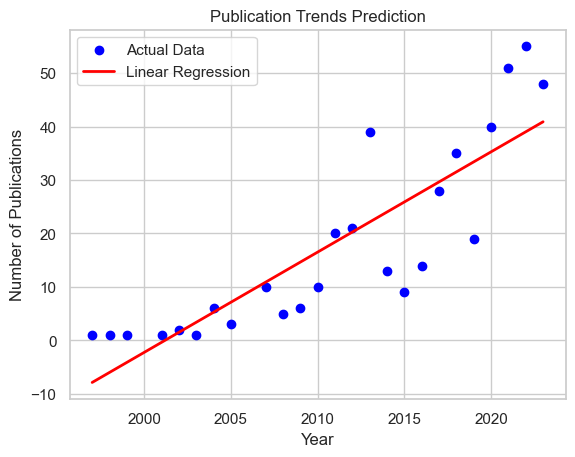

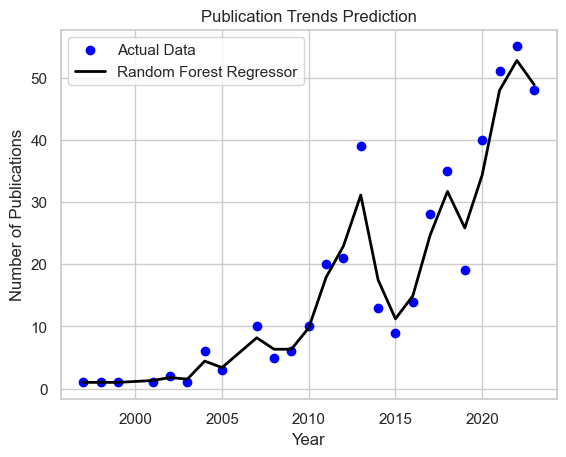

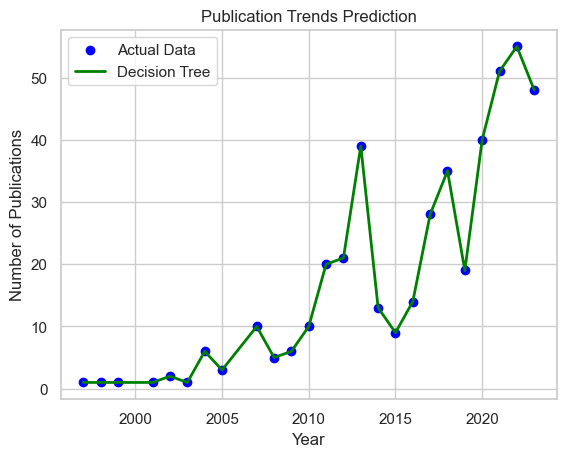

In [50]:
#Linear Regression predictions
plt.scatter(X, y, color='blue', label='Actual Data')
plt.plot(X, predictions, color='red', linewidth=2, label='Linear Regression')
plt.title('Publication Trends Prediction')
plt.xlabel('Year')
plt.ylabel('Number of Publications')
plt.legend()
plt.show()

#Random Forest Regressor
plt.scatter(X, y, color='blue', label='Actual Data')
plt.plot(X, rf_predictions, color='black', linewidth=2, label='Random Forest Regressor')
plt.title('Publication Trends Prediction')
plt.xlabel('Year')
plt.ylabel('Number of Publications')
plt.legend()
plt.show()

#Decision Tree predictions
plt.scatter(X, y, color='blue', label='Actual Data')
plt.plot(X, tree_predictions, color='green', linewidth=2, label='Decision Tree')
plt.title('Publication Trends Prediction')
plt.xlabel('Year')
plt.ylabel('Number of Publications')
plt.legend()
plt.show()
